Original class distribution:
Total samples: 1437
Train samples: 1150
Test samples: 287

Train class distribution:
activity_id_num
0      22
1      19
2      25
3      15
4      29
5      22
6      50
7      66
8      38
9      49
10     43
11     43
12     23
13     19
14     15
15     18
16     11
17     32
18     18
19     17
20     38
21     28
22     23
23     35
24     24
25      6
26     16
27     19
28     15
29     27
30     17
31     34
32     24
33      7
34     30
35     11
36    136
37     31
38     33
39     22
Name: count, dtype: int64

Test class distribution:
activity_id_num
0      5
1      5
2      6
3      4
4      7
5      5
6     13
7     16
8     10
9     12
10    11
11    11
12     5
13     5
14     4
15     5
16     2
17     8
18     5
19     4
20     9
21     7
22     6
23     9
24     6
25     1
26     4
27     5
28     4
29     7
30     4
31     9
32     5
33     2
34     8
35     2
36    34
37     8
38     8
39     6
Name: count, dtype: int64

RESAMPLING OPTI

/home/siyang/miniconda3/envs/cuhkx-example/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/siyang/miniconda3/envs/cuhkx-example/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


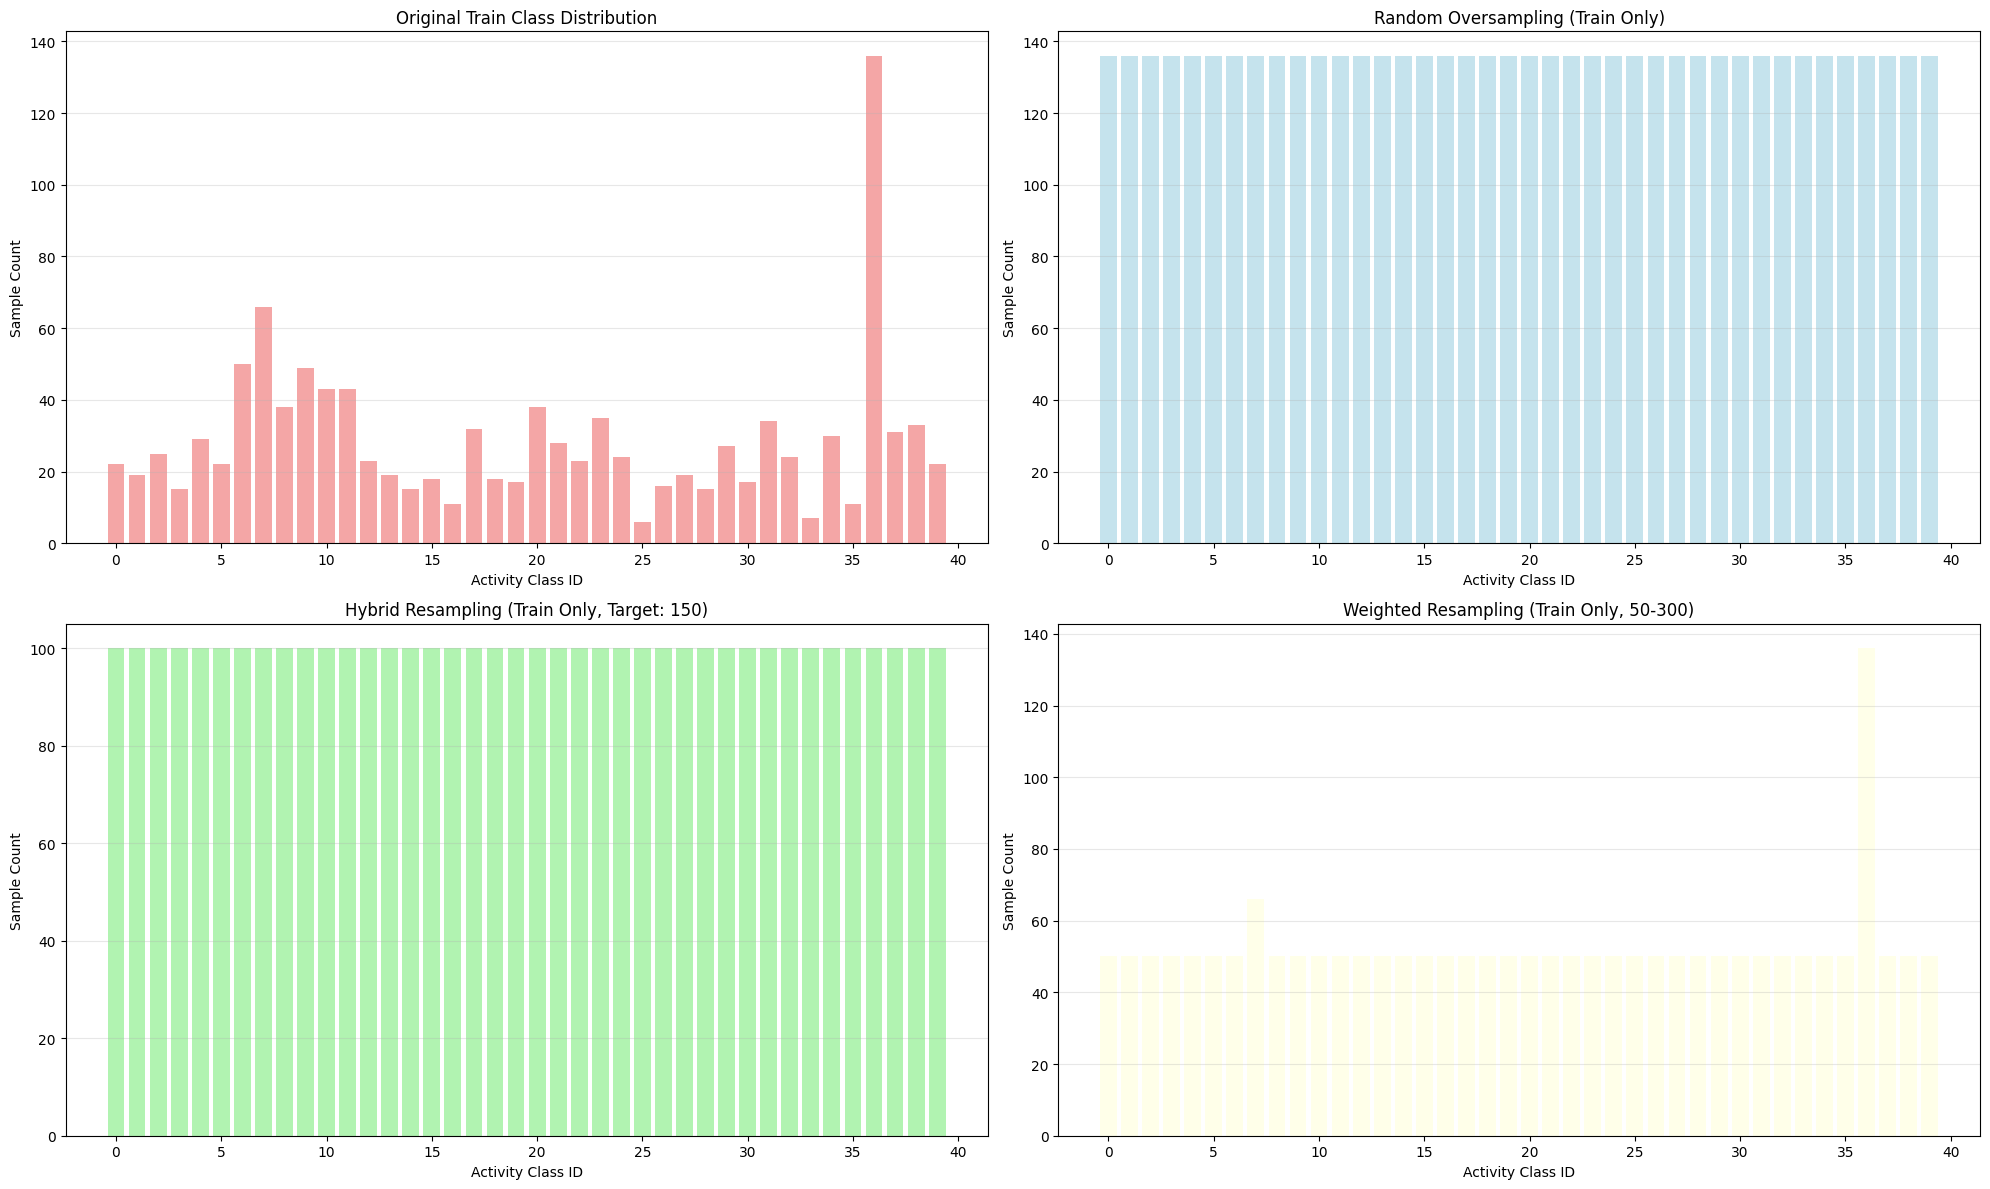


FINAL RESAMPLED DATASET SUMMARY:
Original dataset size: 1437
  - Original train size: 1150
  - Original test size: 287
Resampled dataset size: 4287
  - Resampled train size: 4000
  - Test size (unchanged): 287
Train size increase: 247.8%
Original train imbalance ratio: 22.67
New train imbalance ratio: 1.00
Imbalance reduction: 95.6%

Test data verification:
Original test samples: 287
Final test samples: 287
Test data unchanged: True

Saved to: /aiot-nvme-15T-x2-hk01/siyang/CUHK-X-example/SM/Code/imu/dataset/activity_40_hybrid_resampled_v2/dataset_fold_4.csv


In [ ]:
# resample dataset to mitigate class imbalance - ONLY FOR TRAINING DATA
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
import numpy as np
import pandas as pd
import os

# First, let's analyze the current class distribution
print("Original class distribution:")
fold_name='dataset_fold_4'
dataset_path=f'/YOUR/PATH/TO/CUHKX/SM/Code/imu/data_imu/activity_40/{fold_name}.csv'
df = pd.read_csv(dataset_path)

# Separate train and test data
df_train = df[df['data_type'] == 'train'].copy()
df_test = df[df['data_type'] == 'test'].copy()

print(f"Total samples: {len(df)}")
print(f"Train samples: {len(df_train)}")
print(f"Test samples: {len(df_test)}")

print("\nTrain class distribution:")
train_class_counts = df_train['activity_id_num'].value_counts().sort_index()
print(train_class_counts)

print("\nTest class distribution:")
test_class_counts = df_test['activity_id_num'].value_counts().sort_index()
print(test_class_counts)

# Strategy 1: Random Oversampling (Simple but effective) - TRAIN ONLY
def random_oversample_train_only(df_train, df_test, target_column='activity_id_num', strategy='auto'):
    """
    Random oversampling to balance classes - applies only to training data
    strategy: 'auto', 'minority', or dict with specific target counts
    """
    # Separate features and target for training data only
    X_train = df_train.drop(columns=[target_column])
    y_train = df_train[target_column]
    
    # Apply random oversampling to training data
    ros = RandomOverSampler(random_state=42, sampling_strategy=strategy)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
    # Combine back into dataframe
    df_train_resampled = X_train_resampled.copy()
    df_train_resampled[target_column] = y_train_resampled
    
    # Combine resampled training data with unchanged test data
    df_combined = pd.concat([df_train_resampled, df_test], ignore_index=True)
    
    return df_combined, df_train_resampled

# Strategy 2: Hybrid approach - Oversample minority, undersample majority - TRAIN ONLY
def hybrid_resample_train_only(df_train, df_test, target_column='activity_id_num', target_samples_per_class=150):
    """
    Hybrid resampling: oversample classes below target, undersample classes above target
    Applies only to training data
    """
    class_counts = df_train[target_column].value_counts()
    
    # Separate classes into groups
    oversample_classes = class_counts[class_counts < target_samples_per_class].index
    undersample_classes = class_counts[class_counts > target_samples_per_class].index
    balanced_classes = class_counts[class_counts == target_samples_per_class].index
    
    resampled_dfs = []
    
    # Keep balanced classes as is
    for class_id in balanced_classes:
        class_df = df_train[df_train[target_column] == class_id]
        resampled_dfs.append(class_df)
    
    # Oversample minority classes
    for class_id in oversample_classes:
        class_df = df_train[df_train[target_column] == class_id]
        current_count = len(class_df)
        
        if current_count == 0:  # Skip if no training samples for this class
            continue
            
        # Calculate how many additional samples needed
        additional_needed = target_samples_per_class - current_count
        
        # Resample with replacement
        oversampled = resample(class_df, 
                             n_samples=additional_needed, 
                             random_state=42, 
                             replace=True)
        
        # Combine original and oversampled
        resampled_dfs.append(pd.concat([class_df, oversampled]))
    
    # Undersample majority classes
    for class_id in undersample_classes:
        class_df = df_train[df_train[target_column] == class_id]
        
        # Randomly sample target number
        undersampled = resample(class_df, 
                              n_samples=target_samples_per_class, 
                              random_state=42, 
                              replace=False)
        resampled_dfs.append(undersampled)
    
    # Combine all resampled training data
    df_train_resampled = pd.concat(resampled_dfs, ignore_index=True)
    
    # Combine resampled training data with unchanged test data
    df_combined = pd.concat([df_train_resampled, df_test], ignore_index=True)
    
    return df_combined, df_train_resampled

# Strategy 3: Weighted sampling (for very imbalanced long-tail classes) - TRAIN ONLY
def weighted_resample_train_only(df_train, df_test, target_column='activity_id_num', min_samples=50, max_samples=300):
    """
    Weighted resampling that ensures minimum samples for all classes
    while capping maximum samples to prevent over-representation
    Applies only to training data
    """
    class_counts = df_train[target_column].value_counts()
    resampled_dfs = []
    
    for class_id in range(40):  # Assuming 40 classes (0-39)
        class_df = df_train[df_train[target_column] == class_id]
        current_count = len(class_df)
        
        if current_count == 0:
            continue
        elif current_count < min_samples:
            # Oversample to minimum
            target_count = min_samples
            oversampled = resample(class_df, 
                                 n_samples=target_count, 
                                 random_state=42, 
                                 replace=True)
            resampled_dfs.append(oversampled)
        elif current_count > max_samples:
            # Undersample to maximum
            undersampled = resample(class_df, 
                                  n_samples=max_samples, 
                                  random_state=42, 
                                  replace=False)
            resampled_dfs.append(undersampled)
        else:
            # Keep as is
            resampled_dfs.append(class_df)
    
    df_train_resampled = pd.concat(resampled_dfs, ignore_index=True)
    
    # Combine resampled training data with unchanged test data
    df_combined = pd.concat([df_train_resampled, df_test], ignore_index=True)
    
    return df_combined, df_train_resampled

# Apply one of the resampling strategies
print("\n" + "="*50)
print("RESAMPLING OPTIONS (TRAIN DATA ONLY):")
print("="*50)

# Option 1: Random Oversampling
print("\n1. Random Oversampling (Recommended) - Train Only:")
df_combined_over, df_train_oversampled = random_oversample_train_only(df_train, df_test)
print(f"Original train size: {len(df_train)}")
print(f"Resampled train size: {len(df_train_oversampled)}")
print(f"Test size (unchanged): {len(df_test)}")
print(f"Combined size: {len(df_combined_over)}")
print("New train class distribution:")
print(df_train_oversampled['activity_id_num'].value_counts().sort_index())

# Option 2: Hybrid approach
print("\n2. Hybrid Resampling (target: 150 samples per class) - Train Only:")
df_combined_hybrid, df_train_hybrid = hybrid_resample_train_only(df_train, df_test, target_samples_per_class=100)
print(f"Original train size: {len(df_train)}")
print(f"Resampled train size: {len(df_train_hybrid)}")
print(f"Test size (unchanged): {len(df_test)}")
print(f"Combined size: {len(df_combined_hybrid)}")
print("New train class distribution:")
print(df_train_hybrid['activity_id_num'].value_counts().sort_index())

# Option 3: Weighted resampling (Conservative approach)
print("\n3. Weighted Resampling (min: 50, max: 300) - Train Only:")
df_combined_weighted, df_train_weighted = weighted_resample_train_only(df_train, df_test, min_samples=50, max_samples=300)
print(f"Original train size: {len(df_train)}")
print(f"Resampled train size: {len(df_train_weighted)}")
print(f"Test size (unchanged): {len(df_test)}")
print(f"Combined size: {len(df_combined_weighted)}")
print("New train class distribution:")
print(df_train_weighted['activity_id_num'].value_counts().sort_index())

# Visualize the resampling results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Original train distribution
axes[0, 0].bar(range(40), [train_class_counts.get(i, 0) for i in range(40)], 
               color='lightcoral', alpha=0.7)
axes[0, 0].set_title('Original Train Class Distribution')
axes[0, 0].set_xlabel('Activity Class ID')
axes[0, 0].set_ylabel('Sample Count')
axes[0, 0].grid(axis='y', alpha=0.3)

# Random oversampling (train only)
over_counts = df_train_oversampled['activity_id_num'].value_counts().sort_index()
axes[0, 1].bar(range(40), [over_counts.get(i, 0) for i in range(40)], 
               color='lightblue', alpha=0.7)
axes[0, 1].set_title('Random Oversampling (Train Only)')
axes[0, 1].set_xlabel('Activity Class ID')
axes[0, 1].set_ylabel('Sample Count')
axes[0, 1].grid(axis='y', alpha=0.3)

# Hybrid resampling (train only)
hybrid_counts = df_train_hybrid['activity_id_num'].value_counts().sort_index()
axes[1, 0].bar(range(40), [hybrid_counts.get(i, 0) for i in range(40)], 
               color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Hybrid Resampling (Train Only, Target: 150)')
axes[1, 0].set_xlabel('Activity Class ID')
axes[1, 0].set_ylabel('Sample Count')
axes[1, 0].grid(axis='y', alpha=0.3)

# Weighted resampling (train only)
weighted_counts = df_train_weighted['activity_id_num'].value_counts().sort_index()
axes[1, 1].bar(range(40), [weighted_counts.get(i, 0) for i in range(40)], 
               color='lightyellow', alpha=0.7)
axes[1, 1].set_title('Weighted Resampling (Train Only, 50-300)')
axes[1, 1].set_xlabel('Activity Class ID')
axes[1, 1].set_ylabel('Sample Count')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Choose your preferred resampled dataset
df_resampled = df_combined_hybrid  # Change this to your preferred option
# df_resampled=df_combined_over
# df_resampled=df_combined_weighted

print(f"\n" + "="*50)
print("FINAL RESAMPLED DATASET SUMMARY:")
print("="*50)
print(f"Original dataset size: {len(df)}")
print(f"  - Original train size: {len(df_train)}")
print(f"  - Original test size: {len(df_test)}")
print(f"Resampled dataset size: {len(df_resampled)}")
print(f"  - Resampled train size: {len(df_resampled[df_resampled['data_type'] == 'train'])}")
print(f"  - Test size (unchanged): {len(df_resampled[df_resampled['data_type'] == 'test'])}")
print(f"Train size increase: {(len(df_resampled[df_resampled['data_type'] == 'train']) / len(df_train) - 1) * 100:.1f}%")

# Calculate new imbalance ratio for training data only
new_train_counts = df_resampled[df_resampled['data_type'] == 'train']['activity_id_num'].value_counts()
new_max = new_train_counts.max()
new_min = new_train_counts.min()
new_imbalance_ratio = new_max / new_min

original_max = train_class_counts.max()
original_min = train_class_counts.min()
original_imbalance_ratio = original_max / original_min

print(f"Original train imbalance ratio: {original_imbalance_ratio:.2f}")
print(f"New train imbalance ratio: {new_imbalance_ratio:.2f}")
print(f"Imbalance reduction: {((original_imbalance_ratio - new_imbalance_ratio) / original_imbalance_ratio) * 100:.1f}%")

# Verify test data remains unchanged
print(f"\nTest data verification:")
print(f"Original test samples: {len(df_test)}")
print(f"Final test samples: {len(df_resampled[df_resampled['data_type'] == 'test'])}")
print(f"Test data unchanged: {len(df_test) == len(df_resampled[df_resampled['data_type'] == 'test'])}")

# Create output directory if it doesn't exist
output_dir = '/aiot-nvme-15T-x2-hk01/siyang/CUHK-X-example/SM/Code/imu/data_imu/activity_40_hybrid_resampled_v2'
os.makedirs(output_dir, exist_ok=True)

# Save the resampled dataset
df_resampled.to_csv(f'{output_dir}/{fold_name}.csv', index=False)
print(f"\nSaved to: {output_dir}/{fold_name}.csv")